### Combined Exploratory Data Analysis (EDA) #3  

Data Subject: Livestock & Vehicle Emissions Datasets  

Data Location:(Project SQLite Database)   
C:\Projects\Emissions_Analysis_Capstone\emissions_data\emissionsdata.sqlite

**Process Steps:**  
    0.0 Download Data from Internet or other source  
    0.1 Place data into project repository
    0.2 Import needed dependencies 
    ---  
    1 Read data (initial statistics, column head)  
    2 Transform/clean where needed (strip, lower, rename, replace)  
    3 Push data to an appropriate container (database)  
    4 Generate basic statistics  
    5 Generate functions for visualizations  
    6 Assess visualizations and statistical data.  

**Step 1**  
Import needed dependencies.

In [164]:
# Core libraries
import pandas as pd
import numpy as np
import sqlite3
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (we’ll use later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Change to project root (adjust as needed)
os.chdir("C:/Projects/Emissions_Analysis_Capstone")

db_path = os.path.join('emissions_data', 'emissionsdata.sqlite')
os.makedirs(os.path.dirname(db_path), exist_ok=True)
conn = sqlite3.connect(db_path)

**Step 2**  
Data Extraction from SQLite Database

In [165]:
# === Livestock query (filtered) ===
livestock_query = """
SELECT
    region,
    animal_type,
    production_system,
    commodity,
    co2_emissions_kg,
    n2o_emissions_kg
FROM livestock_emissions
WHERE region = 'North America'
  AND animal_type = 'Cattle'
  AND production_system = 'Aggregated'
  AND commodity = 'Meat';
"""
livestock_df = pd.read_sql(livestock_query, conn)

'''
# Filter livestock to North America, cattle, meat commodity
cattle_meat_na_df = livestock_df[
    (livestock_df["region"] == "North America") &
    (livestock_df["animal_type"] == "Cattle") &
    (livestock_df["commodity"] == "Meat")
].copy()
'''
cattle_meat_na_df = livestock_df.copy()

# Calculate total cattle CO2 emissions
cattle_total_CO2_kg = cattle_meat_na_df["co2_emissions_kg"].sum()
cattle_total_CO2_million_tonnes = cattle_total_CO2_kg / 1e6

# === Vehicle query ===
vehicle_query = """
SELECT
    make,
    model,
    co2_emissions_g_per_km,
    fuel_type
FROM vehicle_emissions;
"""
vehicle_df = pd.read_sql(vehicle_query, conn)

**Step 3**  
Data Cleaning and Transformation

In [166]:
# Convert CO2 column to numeric
vehicle_df["co2_emissions_g_per_km"] = pd.to_numeric(
    vehicle_df["co2_emissions_g_per_km"], errors="coerce"
)

# Convert g/km → kg/km
vehicle_df["co2_emissions_kg_per_km"] = vehicle_df["co2_emissions_g_per_km"] / 1000

# Multiply by average annual mileage to get kg/year
AVG_KM_PER_YEAR = 16094  # 10,000 miles
vehicle_df["co2_emissions_kg_per_year"] = vehicle_df["co2_emissions_kg_per_km"] * AVG_KM_PER_YEAR

# Dataset aggregates 7 years, divide by NUM_YEARS to get avg per year
NUM_YEARS = 7
vehicle_df["co2_emissions_kg_per_year"] = vehicle_df["co2_emissions_kg_per_year"] / NUM_YEARS

**Step 4**  
Emissions Calculations and Aggregation

In [167]:
# --- Livestock totals ---
cattle_total_CO2_kg = livestock_df["co2_emissions_kg"].sum()
cattle_total_CO2_million_tonnes = cattle_total_CO2_kg / 1e6

# Total vehicles sold in 2015 (NA)
TOTAL_VEHICLES_2015 = 17_470_499
vehicle_total_CO2_kg_2015 = vehicle_df["co2_emissions_kg_per_year"].mean() * TOTAL_VEHICLES_2015
vehicle_total_CO2_million_tonnes = vehicle_total_CO2_kg_2015 / 1e6

# CO2 per vehicle per year
vehicle_CO2_per_vehicle_kg_per_year = vehicle_df["co2_emissions_kg_per_year"].mean()

# === Summary comparison (totals + per-vehicle) ===
summary_df = pd.DataFrame(
    {
        "Category": ["Cattle Meat (NA)", "Vehicles (NA, 2015 sales)"],
        "Total_CO2_kg_per_year": [cattle_total_CO2_kg, vehicle_total_CO2_kg_2015],
        "Total_CO2_million_tonnes_per_year": [
            cattle_total_CO2_million_tonnes,
            vehicle_total_CO2_million_tonnes,
        ],
        "Per_Unit_CO2_kg_per_year": [None, vehicle_CO2_per_vehicle_kg_per_year],
    }
)

print("CO₂ Emissions Comparison (Total + Per Vehicle):")
display(summary_df)

CO₂ Emissions Comparison (Total + Per Vehicle):


,Category,Total_CO2_kg_per_year,Total_CO2_million_tonnes_per_year,Per_Unit_CO2_kg_per_year
0,Cattle Meat (NA),2.891361e+10,28913.607678,NaN
1,"Vehicles (NA, 2015 sales)",1.008830e+10,10088.296884,577.447552


**Step 5**  
Visualizations: Total & Per-Unit Comparisons

C:\Users\derek\AppData\Local\Temp\ipykernel_18496\3285907458.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


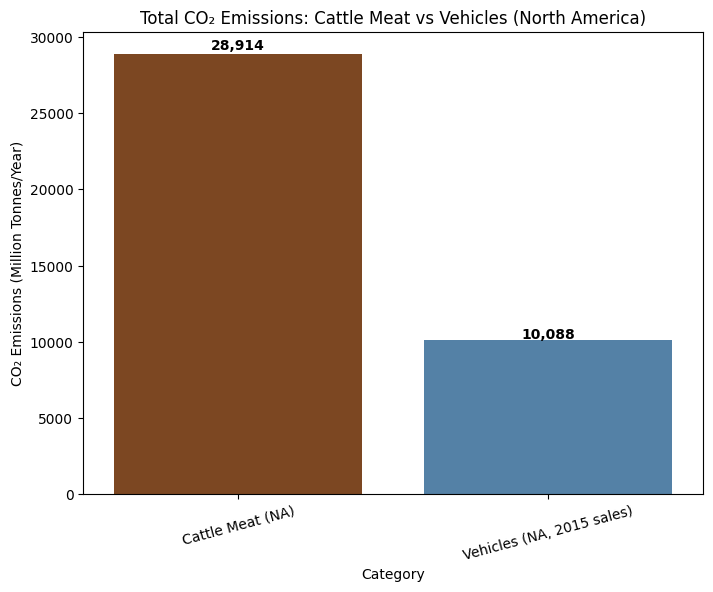

<Figure size 800x600 with 0 Axes>

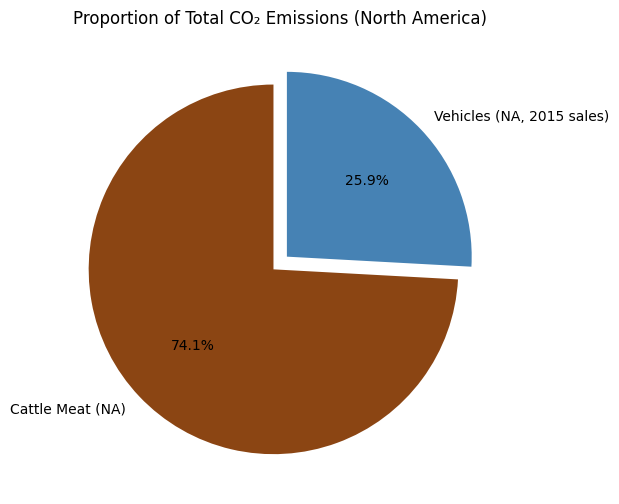

In [168]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Category",
    y="Total_CO2_million_tonnes_per_year",
    data=summary_df,
    palette=["saddlebrown", "steelblue"],
)
plt.ylabel("CO₂ Emissions (Million Tonnes/Year)")
plt.title("Total CO₂ Emissions: Cattle Meat vs Vehicles (North America)")
plt.xticks(rotation=15)
for i, v in enumerate(summary_df["Total_CO2_million_tonnes_per_year"]):
    plt.text(i, v * 1.01, f"{v:,.0f}", ha='center', fontweight='bold')
plt.show()

plt.figure(figsize=(8, 6))
totals = [cattle_total_CO2_million_tonnes, vehicle_total_CO2_million_tonnes]
labels = ["Cattle Meat (NA)", "Vehicles (NA, 2015 sales)"]
colors = ["saddlebrown", "steelblue"]
plt.figure(figsize=(6, 6))
plt.pie(
    totals, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0.05, 0.05)
)
plt.title("Proportion of Total CO₂ Emissions (North America)")
plt.show()

**Step 6**  
Descriptive Statistics

In [169]:
# --- Livestock CO2 statistics ---
print("=== Livestock CO2 Emissions (kg/year) ===")
livestock_stats = livestock_df["co2_emissions_kg"].describe()
display(livestock_stats)

# --- Vehicle CO2 statistics ---
print("\n=== Vehicle CO2 Emissions (kg/year) ===")
vehicle_stats = vehicle_df["co2_emissions_kg_per_year"].describe()
display(vehicle_stats)

=== Livestock CO2 Emissions (kg/year) ===


count    1.000000e+00
mean     2.891361e+10
std               NaN
min      2.891361e+10
25%      2.891361e+10
50%      2.891361e+10
75%      2.891361e+10
max      2.891361e+10
Name: co2_emissions_kg, dtype: float64


=== Vehicle CO2 Emissions (kg/year) ===


count    6282.000000
mean      577.447552
std       136.317160
min       220.717714
25%       478.221714
50%       565.589143
75%       664.452286
max      1200.152571
Name: co2_emissions_kg_per_year, dtype: float64

In [170]:
print(f"Cattle CO₂: {cattle_total_CO2_million_tonnes:.2f} million tonnes/year")
print(f"Vehicle CO₂: {vehicle_total_CO2_million_tonnes:.2f} million tonnes/year")

ratio = vehicle_total_CO2_million_tonnes / cattle_total_CO2_million_tonnes
print(f"Vehicles emit {ratio:.1f}× more CO₂ than cattle in North America.")

Cattle CO₂: 28913.61 million tonnes/year
Vehicle CO₂: 10088.30 million tonnes/year
Vehicles emit 0.3× more CO₂ than cattle in North America.
